# MeshUtility

A collection of python utilities for mesh processing.

## Functions
- [ ] ```colormap_vertex_color```: assign vertex color to visualize a scalar field defined on mesh.
- [x] ```isocurve```: extract isocurves on a scalar field defined on a manifold triangular mesh.
- [x] ```mesh_cut```: cut a mesh along a vertex chain.
- [x] ```mesh_split```: split a mesh by inserting new vertices defined on mesh edges.
- [x] ```sphere_cvt```: iteratively approximate centroidal Voronoi tessellation (CVT) on the unit sphere (kind of uniform sampling).
- [x] ```split_connected_components```: split connected components.
- [ ] ```write_obj_lines```: write polyline as a [Wavefront .obj file](https://en.wikipedia.org/wiki/Wavefront_.obj_file#Line_elements), which can be open with MeshLab.
- [ ] ```pyisocurve``` (C++ based): almost the same as ```isocurve``` above.
- [x] ```pygeodesic``` (C++ based): exact geodesic for triangular meshes.

In [1]:
import numpy as np

import openmesh as om
import meshplot as mp
# mp.offline()
import networkx as nx

import sys
sys.path.append('../../')
import MeshUtility as mu

# Spherical CVT

In [2]:
verts, faces = mu.sphere_cvt(100, iters=100)

100/100


In [3]:
p = mp.plot(verts, faces, return_plot=True)
p.save("../data/sphere_cvt.html")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001642…

Plot saved to file ../data/sphere_cvt.html.


In [4]:
p = mp.plot(verts, c=verts, shading={"point_size": 0.3}, return_plot=True)
p.save("../data/sphere_cvt_v.html")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001642…

Plot saved to file ../data/sphere_cvt_v.html.


## Iso-curve

In [5]:
mesh = om.TriMesh(verts, faces)
field = verts[:, 1]

isocurve = mu.IsoCurve(verts, faces, field)
pts, on_edges, ratios, isocurve_indices = isocurve.extract(0.5)

In [6]:
p = mp.plot(verts, faces, c=field, return_plot=True)
edges = []
for line in isocurve_indices:
    edges.extend([[line[i], line[i+1]] for i in range(len(line)-1)])
edges = np.array(edges, 'i')
p.add_edges(pts, edges, shading={"line_color": "red"})
p.save("../data/isocurve.html")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001642…

Plot saved to file ../data/isocurve.html.


## Mesh Splitting/Cutting

In [7]:
mesh_split, curve_idx = mu.split_mesh(mesh.points(),
                             mesh.face_vertex_indices(),
                             on_edges, ratios)

np.random.seed(5)
d = mp.subplot(verts, faces, c=np.random.rand(*faces.shape), s=[1, 2, 0])
np.random.seed(5)
mp.subplot(mesh_split.points(), mesh_split.face_vertex_indices(), c=np.random.rand(mesh_split.n_faces(), 3), s=[1, 2, 1], data=d)
# add_edges(pts, edges, shading={"line_color": "red"});  # how to add edges in subplot?
d.save("../data/split.html")

Plot saved to file ../data/split.html.


In [8]:
curve_idx_ring = curve_idx + [curve_idx[0]]
curve = [curve_idx_ring[v] for v in isocurve_indices[0]]
mesh_cut, curve_idx = mu.cut_along_curve(mesh_split.points(),
                                         mesh_split.face_vertex_indices(),
                                         curve)
parts = mu.split_connected_components(mesh_cut.points(),
                                      mesh_cut.face_vertex_indices())
n = len(parts)
d = mp.subplot(parts[0].points(), parts[0].face_vertex_indices(), s=[1, n, 0])
for i in range(1, n):
    mp.subplot(parts[i].points(), parts[i].face_vertex_indices(), s=[1, n, i], data=d)
d.save("../data/cut.html")

Plot saved to file ../data/cut.html.


## Geodesic Distance Field

In [9]:
u, v = 0, 20
path_edge, path_ratio = mu.pygeodesic.find_path(verts, faces, u, v)

In [10]:
pts0 = verts[path_edge[:,0]]
pts1 = verts[path_edge[:,1]]
pts = np.multiply(pts0, 1.-path_ratio[:, np.newaxis]) + \
            np.multiply(pts1, path_ratio[:, np.newaxis])
p = mp.plot(verts, faces, return_plot=True)
edges = [[i, i+1] for i in range(pts.shape[0]-1)]
edges = np.array(edges, 'i')
p.add_edges(pts, edges, shading={"line_color": "red"})
p.save("../data/geodesic_path.html")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001642…

Plot saved to file ../data/geodesic_path.html.


In [11]:
mesh_split, source = mu.split_mesh(verts, faces,
                              path_edge, path_ratio)

# compute geodesic distance field
field = mu.pygeodesic.distance_field(mesh_split.points(),
                                     mesh_split.face_vertex_indices(),
                                     source, 0.05)

p = mp.plot(mesh_split.points(), mesh_split.face_vertex_indices(), c=field, return_plot=True)
p.save("../data/geodesic_field.html")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.001642…

Plot saved to file ../data/geodesic_field.html.


## Mesh to Graph

196 196


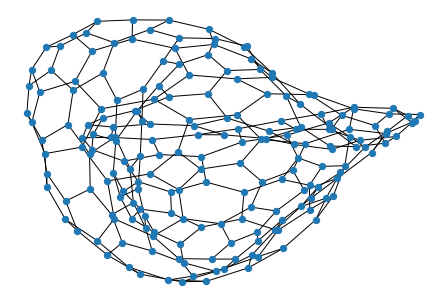

In [12]:
G = mu.ff_graph(mesh)
print(mesh.n_faces(), G.number_of_nodes())
nx.draw(G, node_size=40, pos=nx.spring_layout(G, seed=2))

254 254


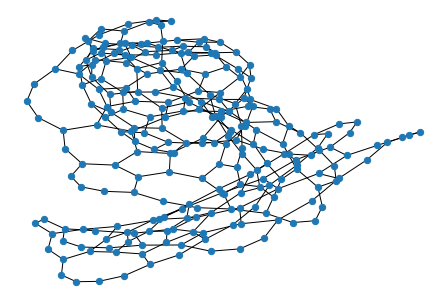

In [13]:
G = mu.ff_graph(mesh_cut)
print(mesh_cut.n_faces(), G.number_of_nodes())
nx.draw(G, node_size=40, pos=nx.spring_layout(G, seed=11))